In [152]:
from qiskit.circuit.library import StatePreparation
from qiskit.circuit import ControlledGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector

from qiskit_aer import AerSimulator
from qiskit import transpile
from random import random
import numpy as np
import matplotlib.pyplot as plt

In [58]:
def prepare_state_generic(state_dict, num_of_qubits):
    coefficients = [state_dict.get(format(i, '0' + str(num_of_qubits) + 'b'), 0) for i in range(2**num_of_qubits)]
    state = StatePreparation(coefficients)
    return state

def prepare_circuit_initial_state(value):
    zero_state_dict = {
        '00000': 1/4,
        '10010': 1/4,
        '01001': 1/4,
        '10100': 1/4,
        '01010': 1/4,
        '11011': -1/4,
        '00110': -1/4,
        '11000': -1/4,
        '11101': -1/4,
        '00011': -1/4,
        '11110': -1/4,
        '01111': -1/4,
        '10001': -1/4,
        '01100': -1/4,
        '10111': -1/4,
        '00101': 1/4
    }
    
    one_state_dict = {
        '11111': 1/4,
        '01101': 1/4,
        '10110': 1/4,
        '01011': 1/4,
        '10101': 1/4,
        '00100': -1/4,
        '11001': -1/4,
        '00111': -1/4,
        '00010': -1/4,
        '11100': -1/4,
        '00001': -1/4,
        '10000': -1/4,
        '01110': -1/4,
        '10011': -1/4,
        '01000': -1/4,
        '11010': 1/4
    }

    initial_state = None
    if value == True:
        initial_state = one_state_dict
    else:
        initial_state = zero_state_dict

    # Prepare state according to the input 
    state_preparation = prepare_state_generic(initial_state, 5)

    return state_preparation

In [139]:
def code_value_test(code, value):
    zero_state_dict = {
        '00000': 1/4,
        '10010': 1/4,
        '01001': 1/4,
        '10100': 1/4,
        '01010': 1/4,
        '11011': -1/4,
        '00110': -1/4,
        '11000': -1/4,
        '11101': -1/4,
        '00011': -1/4,
        '11110': -1/4,
        '01111': -1/4,
        '10001': -1/4,
        '01100': -1/4,
        '10111': -1/4,
        '00101': 1/4
    }
    
    one_state_dict = {
        '11111': 1/4,
        '01101': 1/4,
        '10110': 1/4,
        '01011': 1/4,
        '10101': 1/4,
        '00100': -1/4,
        '11001': -1/4,
        '00111': -1/4,
        '00010': -1/4,
        '11100': -1/4,
        '00001': -1/4,
        '10000': -1/4,
        '01110': -1/4,
        '10011': -1/4,
        '01000': -1/4,
        '11010': 1/4
    }
    dict_to_compare = zero_state_dict
    if value:
        dict_to_compare = one_state_dict

    for key in code:
        key_binary = format(int(key, 16), '09b')[:5]
        if key_binary not in dict_to_compare or abs(dict_to_compare[key_binary] - code[key]) > 1e-9:
            return False
    
    return True

In [150]:
def five_qubit_error_code_circuit(value, probability):
    qc = QuantumCircuit()
    ancillas = AncillaRegister(size = 4)
    qubits = QuantumRegister(size = 5)
    qc.add_register(ancillas)
    qc.add_register(qubits)

    state_preparation = prepare_circuit_initial_state(value)
    qc.append(state_preparation, range(4,9))

    #random pauli gate
    for i in range(4,9):
        random_state = random()
        if random_state < probability:
            qc.x(i)
        elif probability < random_state and random_state < 2*probability:
            qc.y(i)
        elif 2*probability < random_state and random_state < 3*probability:
            qc.z(i)
    


    #error detection
    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.h(3)

    qc.cx(0, 4)
    qc.cz(0, 5, 'Z')

    qc.cz(0, 6, 'Z')
    qc.cx(1, 5)
    qc.cx(2, 4)

    qc.cx(0, 7)
    qc.cz(1, 6, 'Z')
    qc.cz(3, 4, 'Z')

    qc.cz(1, 7, 'Z')
    qc.cx(2, 6)
    qc.cx(3, 5)

    qc.cx(1, 8)
    qc.cz(2, 7, 'Z')

    qc.cz(2, 8, 'Z')
    qc.cx(3, 7)

    qc.cz(3, 8, 'Z')

    qc.barrier()

    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.h(3)    

    # Measure ancillas to check what we need to correct
    error_correction(qc, ancillas)

    # Save the statevectors for the not-collapsed qubits
    qc.save_statevector_dict()
    
    return qc

In [143]:
def error_correction(circuit, ancillas):
    syndromes = ClassicalRegister(4, name="syndromes")
    circuit.add_register(syndromes)
    circuit.measure(ancillas, syndromes)

    with circuit.switch(syndromes) as case:
        with case(0b0001):
            circuit.x(5)
        with case(0b1000):
            circuit.x(4)
        with case(0b1100):
            circuit.x(8)
        with case(0b0110):
            circuit.x(7)
        with case(0b0011):
            circuit.x(6)
        with case(0b1010):
            circuit.z(5)
        with case(0b0101):
            circuit.z(4)
        with case(0b0010):
            circuit.z(8)
        with case(0b1001):
            circuit.z(7)
        with case(0b0100):
            circuit.z(6)
        with case(0b1011):
            circuit.y(5)
        with case(0b1101):
            circuit.y(4)
        with case(0b1110):
            circuit.y(8)
        with case(0b1111):
            circuit.y(7)
        with case(0b0111):
            circuit.y(6)
            

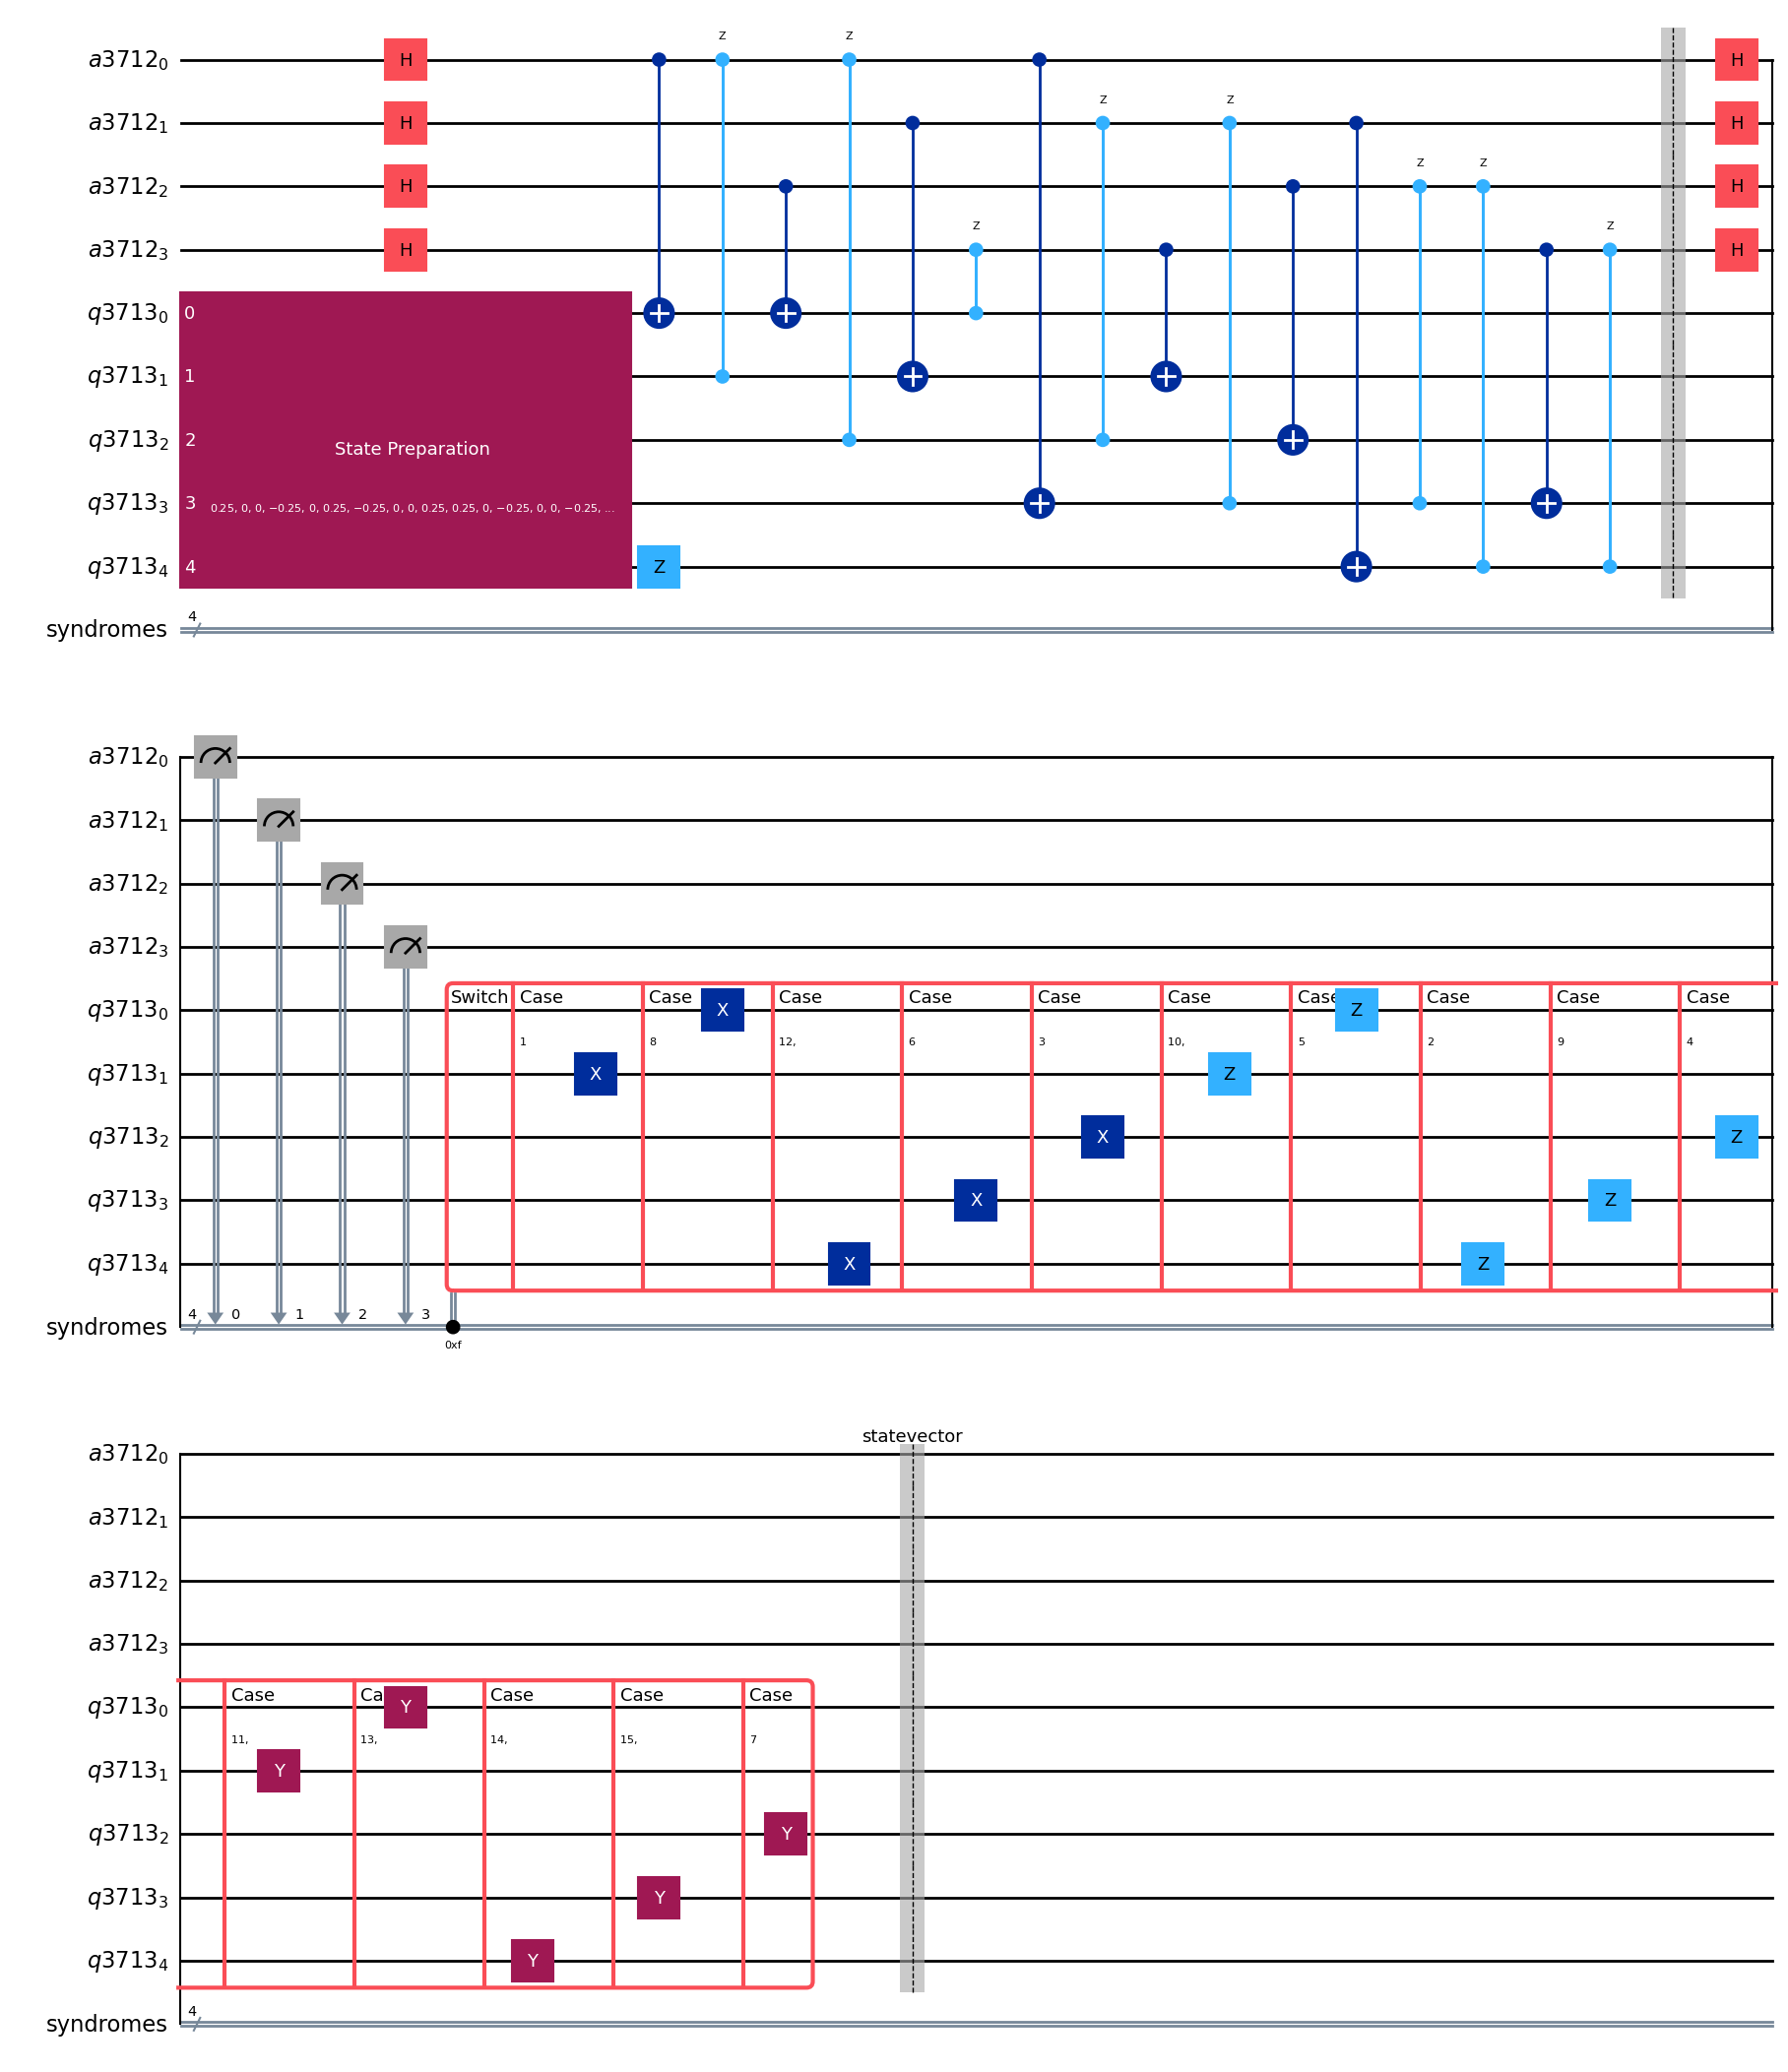

In [162]:
# Create the circuit for the five-qubit error correction code
circuit = five_qubit_error_code_circuit(0, 1/15)
circuit.draw(output="mpl")

In [163]:
# Create a simulator backend and run the circuit to test if it works correctly
simulator = AerSimulator()

# Transpile the circuit for the backend
compiled_circuit = transpile(circuit, simulator)

# Run the circuit
job = simulator.run(compiled_circuit, shots=1)

# Get the measurement counts
result = job.result()
data = result.data()
result.get_counts()

{'0010': 1}

In [164]:
code_value_test(data['statevector'], 0)

True

In [165]:
#Assemble success statistics
success_rate = []
num_datapoints = 20
mesh_size = 0.01
num_iteration = 100

for p in range(num_datapoints):
    success_rate = success_rate + [0]
    for run in range(num_iteration):
        start = round(random())
        circuit = five_qubit_error_code_circuit(1, mesh_size*p)
        simulator = AerSimulator()
        compiled_circuit = transpile(circuit, simulator)
        job = simulator.run(compiled_circuit, shots=1)
        if code_value_test(job.result().data()['statevector'], start):
            success_rate[p] = success_rate[p] + 1
    success_rate[p] = success_rate[p]/num_iteration

In [166]:
num_datapoints = 20
mesh_size = 0.01
num_iteration = 100

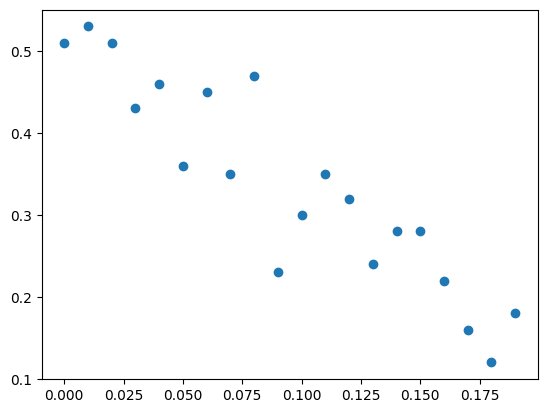

In [169]:
#plot result
plt.plot([mesh_size*p for p in range(num_datapoints)],success_rate, 'o')

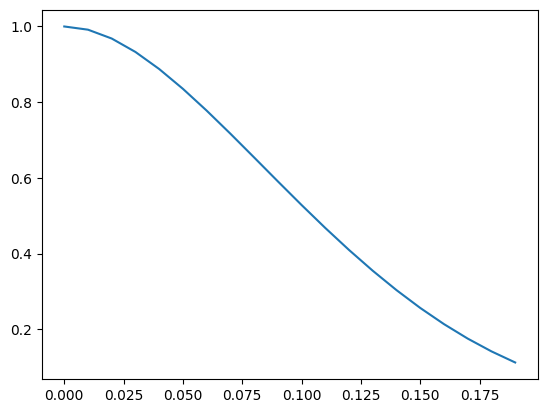

In [170]:
#plot ideal: (1-3p)^5 + 5*3p*(1-3p)^4
plt.plot([mesh_size*p for p in range(num_datapoints)], [(1-3*mesh_size*p)**5+5*3*mesh_size*p*(1-3*mesh_size*p)**4 for p in range(num_datapoints)])